#LDA (Latent Dirichlet allocation)
LDA主題模型: 它是一種統計模型，用於標記出現在文檔集合中的抽象“主題”，這些主題最能代表這個文檔集合中的信息。

## Theoretical Overview

### LDA 的基本精神：文件生成的機制
LDA 有趣的地方是，該模型假設了「人類撰寫一篇有意義文件」的隱含機制：每篇文件都是由少數幾個「主題 (Topic)」所組成，而且每個主題都可以由少數幾個重要的「用詞 (Word)」描述。在 LDA 模型中，我們假設文本 *D* 生成時，背後有 K 個重要的隱含主題 。每個主題 t = 1, 2, ... , K 都可以用 V 個用詞中的其中幾個用詞來描述。文件中的每個用詞 $w_{ij}$ 其實都對應到這 K 個主題中的一個主題，我們將這個用詞的主題紀錄為 $T_{ij}$。下面的圖示清楚解釋 LDA 在描述「主題−用詞−文件」間的關聯，然而在真實的世界中，我們唯一觀察到的就是文本，因此主題與對應的用詞是我們需要透過觀察大量文本來推論出的結構。

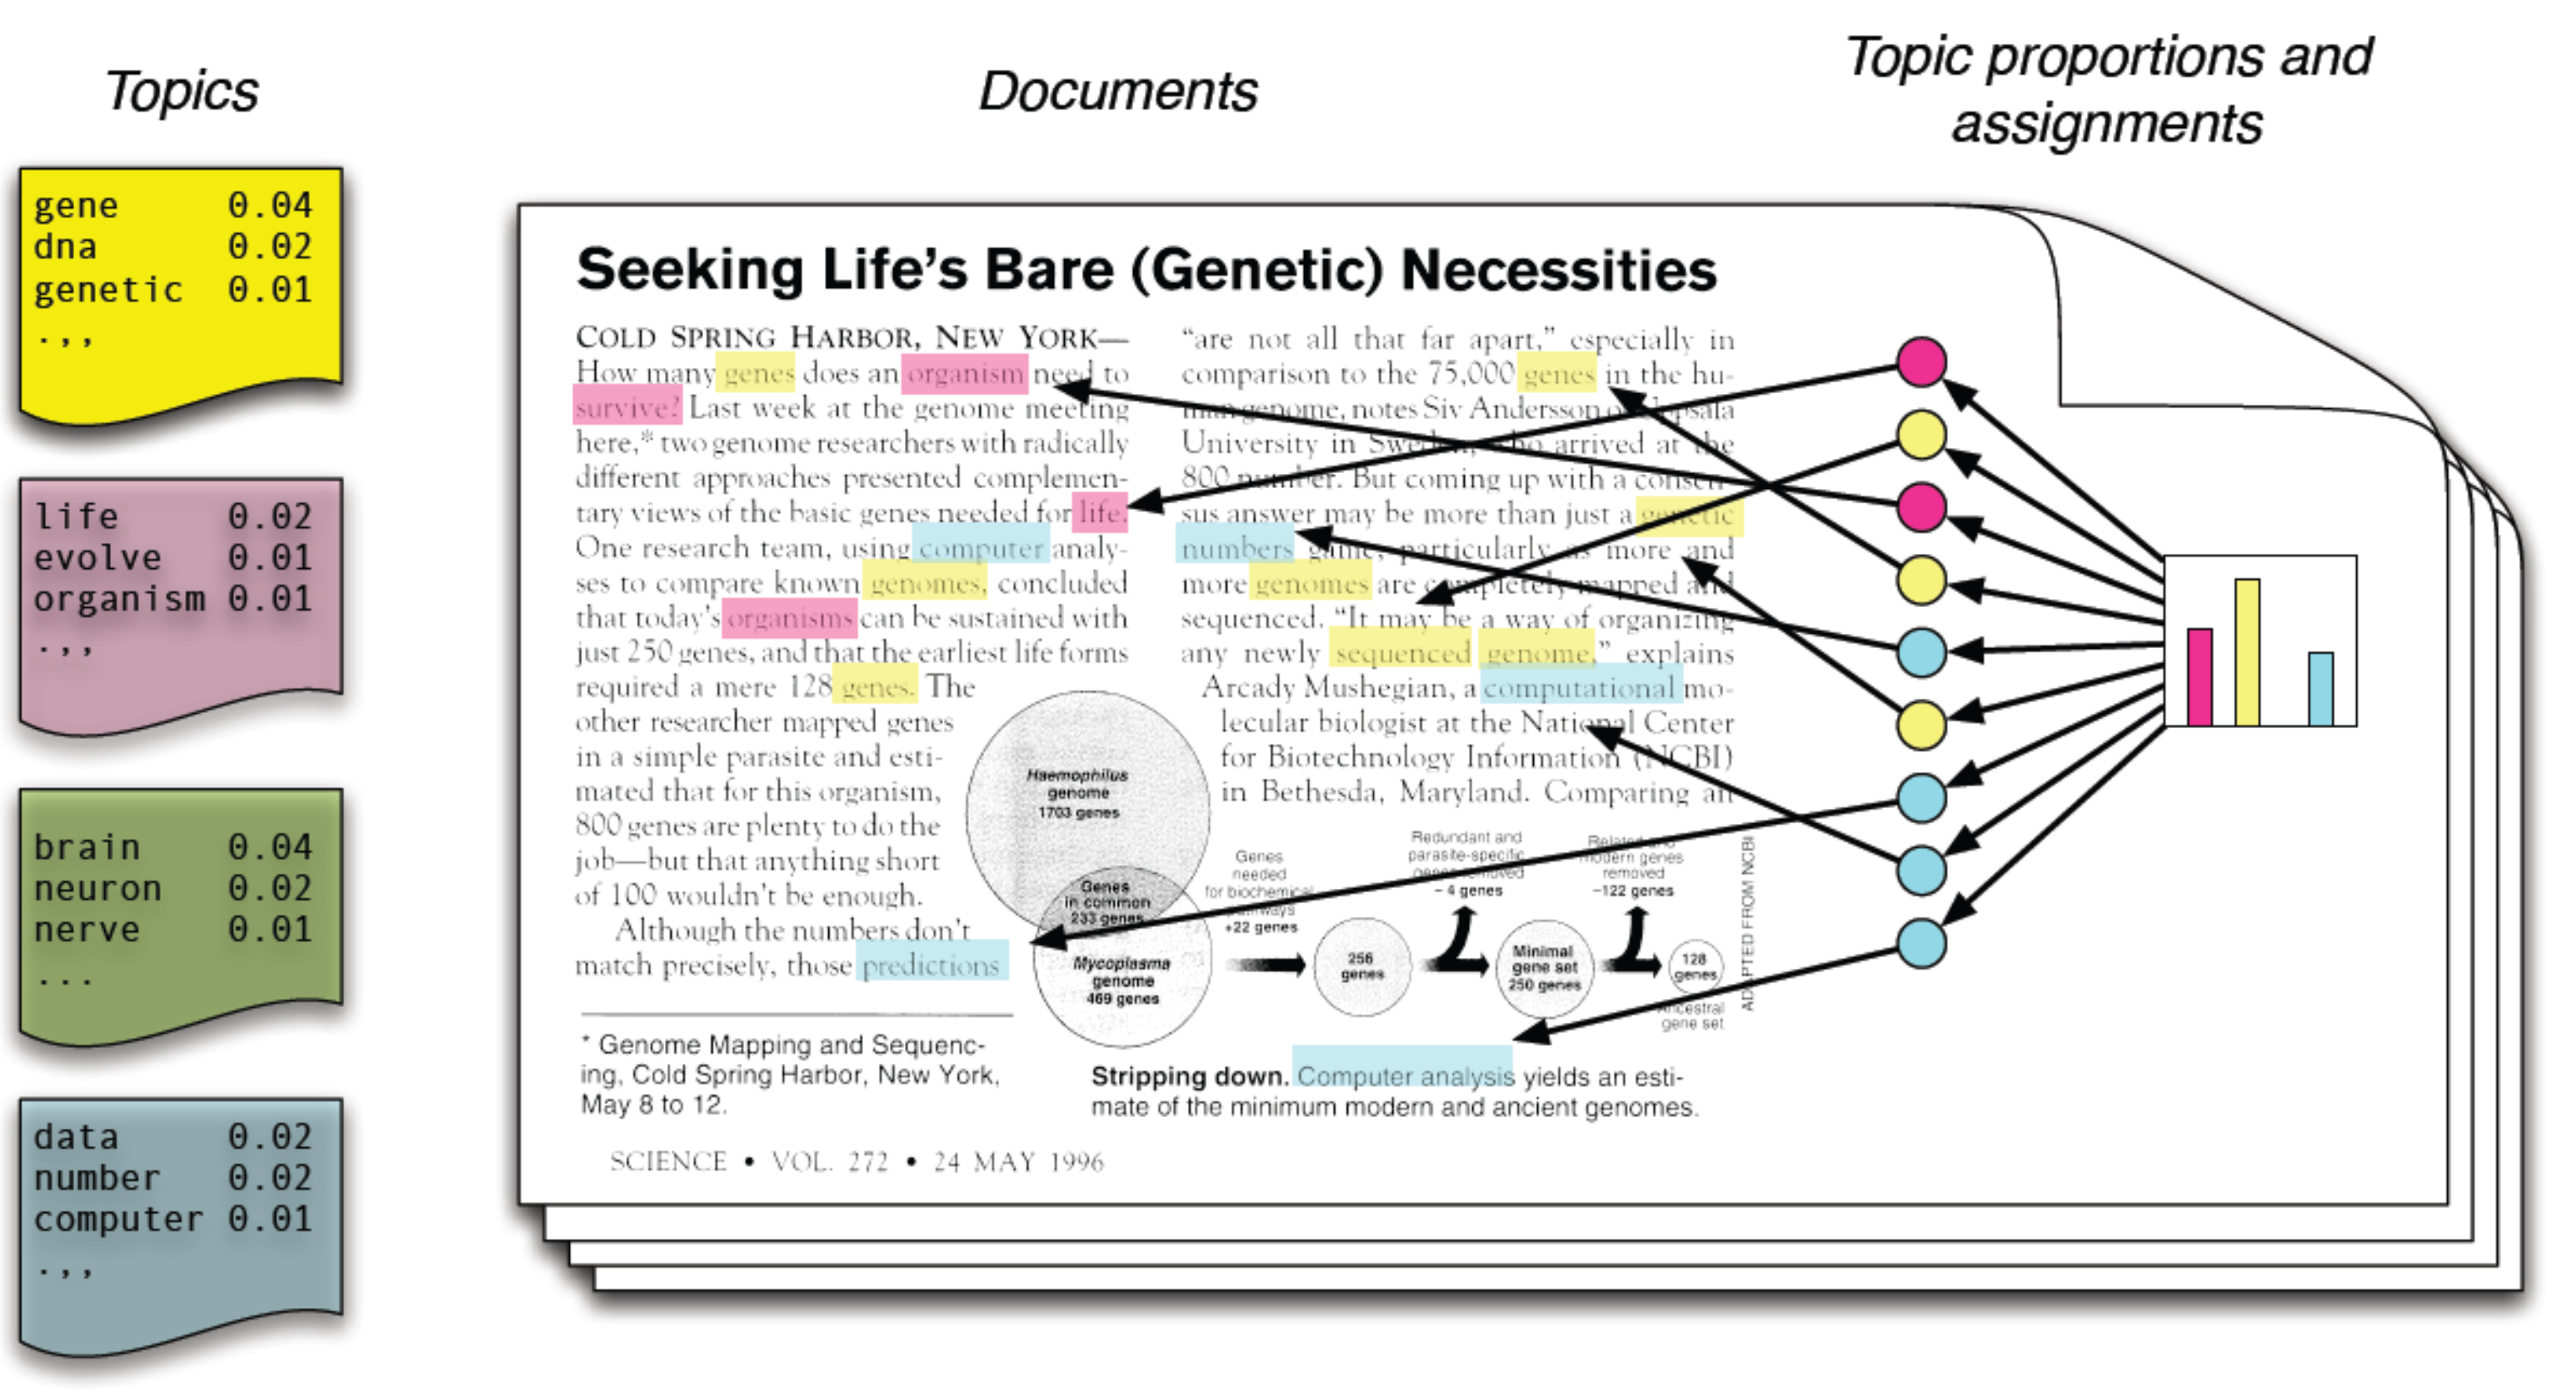

總結來說，LDA 假設人們在撰寫該文本的一篇文件時，有以下幾個重要的生成步驟：


*   決定第 i  篇文件的用詞數 $N_i$
*   決定第 i  篇文件在 k個主題各自出現的傾向程度為 $ \boldsymbol\theta_i = \begin{bmatrix} \theta_{1}, & \cdots, & \theta_{k}\end{bmatrix}$。
*   撰寫第 i  篇文件的第 j 個用詞 $w_{ij}$時：


> 1.   會先選擇一個對應的主題 $z_{ij} = t$；
> 2.   根據主題 t，接著挑選一個可以用來描述該主題的用詞當作 $w_{ij}$；
> 3.   對於第 t 個主題，詞庫中用詞各自出現的傾向程度為 $\boldsymbol\phi_t = \begin{bmatrix} \phi^t_{1}, & \cdots, & \phi^t_{V}\end{bmatrix}$。



根據定義，LDA是給定語料庫的生成概率模型。其基本思想是將文檔表示爲潛在主題的隨機混合，並對每個主題通過單詞分佈進行特徵化。

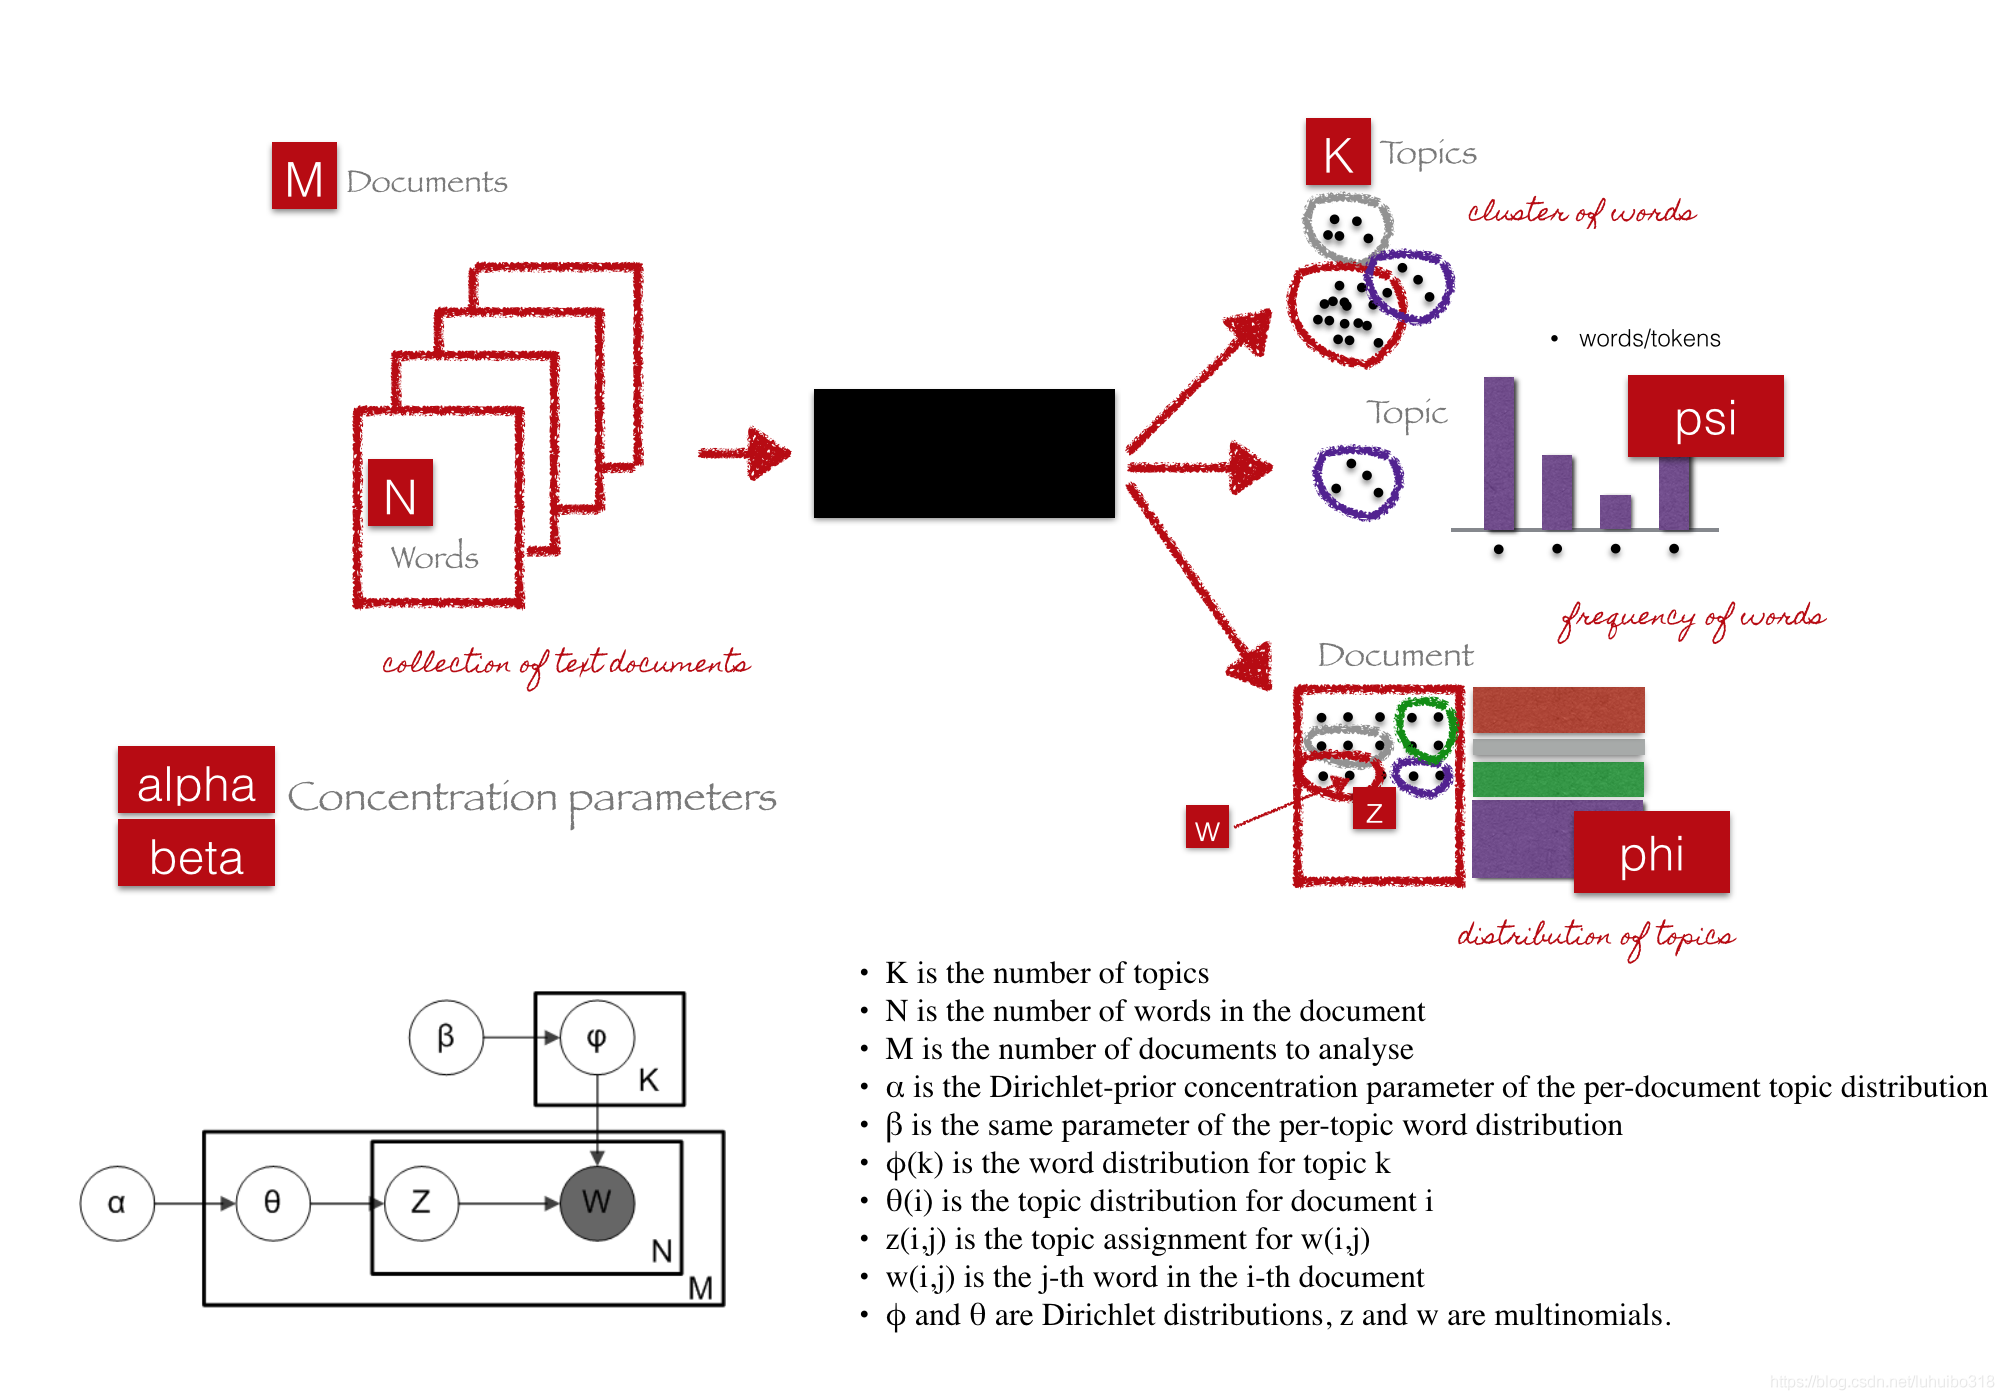

我們可以把LDA的處理過程進行如下描述，給定M個文檔、N個單詞和估計的K個主題, LDA模型訓練輸出的結果：

*   psi，表示每個主題K的單詞分佈
*   phi，表示每個文檔 i 的主題分佈。


### Parameters of LDA
α參數是Dirichlet先驗濃度參數,表示文檔-主題密度，α值越高，就可以假定文檔由更多的主題組成，從而導致每個文檔的主題分佈更加具體。

β參數與先驗濃度參數相同,表示主題詞密度的，β值越高，就可以假定主題由大部分單詞組成，從而導致每個主題的單詞分佈更加具體。

## Example

Intercom Project:
Find any potential topic of "others" conversation

In [ ]:
#@title Install package
!pip install pyLDAvis==2.1.2

     |████████████████████████████████| 1.6 MB 5.1 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97738 sha256=7a71d1461ab82dabf26f5398be74e20b061aa5724c223452295284a5d6b16937
  Stored in directory: /root/.cache/pip/wheels/3b/fb/41/e32e5312da9f440d34c4eff0d2207b46dc9332a7b931ef1e89
Successfully built pyLDAvis


In [ ]:
#@title Import package
from google.colab import auth
from google.colab import drive
from google.cloud import bigquery

from datetime import datetime
import numpy as np
import pandas as pd

import codecs
import os
import re
import jieba
from bs4 import BeautifulSoup

import pyLDAvis
import pyLDAvis.sklearn

from gensim import corpora, models
from gensim.models import CoherenceModel

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

import gc
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [ ]:
# @title Authentication (Google <-> Colab)
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
drive.mount('/content/drive')
print('Authenticated')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Authenticated


In [ ]:
# @title Jieba setting
# 讀 dict.txt 檔案
file_path = '/content/drive/MyDrive/Colab Notebooks/jieba/dict.txt'
jieba.set_dictionary(file_path)

# set_stop_words
# stop_path = '/content/drive/MyDrive/Colab Notebooks/jieba/baidu_stopwords.txt'
stop_path = '/content/drive/MyDrive/Colab Notebooks/jieba/stoped.txt'

stopwords = [line.strip() for line in codecs.open(stop_path, 'r', 'utf-8').readlines()] 
stopwords_topic = ['請問', '嗎', '想', '為', '會', '在', '的話', '請', '怎麼', '你好', '再', 
                   '後', '與', '這邊', '相關', '中', '都', '謝謝', '什麼', '想要', '詢問',
                   '確認', '一個', 'shopline', '有', '沒有']
stopwords.extend(stopwords_topic)

word_list = ['店到店',
             '7-11',
             '購物金',
             'GMV',
             'google ads',
             'facebook',
             'pixel',
             '像素',
             '金流',
             '物流',
             '貨到付款',
             '網域',
             '超商取貨',
             '第三方',
             'pos',
             'ipad',
             '廣告',
             '方案',
             '直播',
             '後台',
             '電子發票',
             'line pay',
             'linepay',
             '搜尋',
             '抽獎',
             'stripe',
             '庫存',
             '倉庫',
             '庫點',
             '鯨躍',
             '訊息中心',
             '官網',
             '關閉',
             '訂閱',
             '獎勵',
             '公司名稱',
             '登入',
             '密碼',
             '詐騙',
             '蝦皮',
             '鼎新',
             'shopline ad',
             '行銷',
             '追蹤',
             'smart ads',
             'google analytics'
             ]
for word in word_list:
    jieba.add_word(word, freq=None, tag=None)



Building prefix dict from /content/drive/MyDrive/Colab Notebooks/jieba/dict.txt ...
Loading model from cache /tmp/jieba.u4e0deaaf5fdff1da756b309039a2d83e.cache
Loading model cost 1.588 seconds.
Prefix dict has been built successfully.


In [ ]:
# @title Data Preprocessing
# query

query = '''

WITH merchants AS (
SELECT
  _id AS merchant_id,
  handle,
  name AS store_name,
  tags,
  base_currency_code,
  plan_type,
  profile_type
FROM
  `shopline-test.looker_prod.merchants_hourly`
WHERE 
  base_currency_code IN ('SGD', 'MYR')
  AND NOT ((REGEXP_CONTAINS(IFNULL( email, ''), r'@shopline\w*.com|@yy.com') AND internal_account_googlesheet IS NULL) OR IFNULL(internal_account_googlesheet,'') = 'Y')
  AND NOT REGEXP_CONTAINS(current_plan_key, r"free|_trial|locked")
  AND GMV_tier != 'Micro'   ## must have GMV in the past 90 days
#   AND REGEXP_CONTAINS( plan_type , r'POS|O2O')
)
, order_items AS (
  SELECT
    merchant_id,
    handle,
    CASE
      WHEN tags IN ('electronics,travel & souvenirs,sports','women,beauty') THEN 'other'
      WHEN tags IS NULL THEN 'other'
      ELSE tags
      END AS tags,
    store_name,
    base_currency_code,
    item_id AS product_id,
    object_data.title_translations_zh_hant AS product_name_zh,
    object_data.title_translations_en AS product_name_en,
    CONCAT( COALESCE(object_data.title_translations_zh_hant,''), COALESCE(object_data.title_translations_en,'') ) AS product_name,
    item_price_cents,
    SUM(quantity) AS Sold_Qty,
    ROW_NUMBER() OVER (PARTITION BY merchant_id ORDER BY SUM(quantity) DESC )AS Qty_rn,
    
    SUM(total_cents) AS Sold_Amount,
    ROW_NUMBER() OVER (PARTITION BY merchant_id ORDER BY SUM(total_cents) DESC )  AS Amount_rn,
    
    COUNT(DISTINCT item_id) OVER(PARTITION BY merchant_id) AS Total_Products,
    SUM( SUM(total_cents) ) OVER(PARTITION BY merchant_id) AS Total_Sales
  FROM   	
  `shopline-test.looker_prod.order_items_hourly` AS order_items
    JOIN merchants
      ON order_items.item_owner_id = merchants.merchant_id
  WHERE 
    DATE(created_at, 'Asia/Taipei') <= DATE(TIMESTAMP_ADD(TIMESTAMP_TRUNC(TIMESTAMP(FORMAT_TIMESTAMP('%F %H:%M:%E*S', CURRENT_TIMESTAMP(), 'Asia/Hong_Kong')), DAY), INTERVAL -1 DAY))
    AND DATE(created_at, 'Asia/Taipei') >= DATE(TIMESTAMP_ADD(TIMESTAMP_TRUNC(TIMESTAMP(FORMAT_TIMESTAMP('%F %H:%M:%E*S', CURRENT_TIMESTAMP(), 'Asia/Hong_Kong')), DAY), INTERVAL -91 DAY))
    AND item_type = 'Product'
    AND status != 'removed'
    AND quantity > 0 AND total_cents > 0
  GROUP BY 
    merchant_id,
    handle,
    tags,
    store_name,
    base_currency_code,
    product_id,
    product_name_zh,
    product_name_en,
    item_price_cents
)
SELECT
  *EXCEPT(item_price_cents,Sold_Amount,Total_Sales),
  ROUND( Qty_rn / MAX(Qty_rn) OVER(PARTITION BY merchant_id) ,2) AS Qty_rank,
  ROUND( Amount_rn / MAX(Amount_rn) OVER(PARTITION BY merchant_id) ,2) AS Amount_rank
FROM 
  order_items
-- WHERE 
--   handle = 'monstertraining'
ORDER BY 
  base_currency_code,
  Total_Products DESC,
  merchant_id,
  Sold_Qty DESC

'''

In [ ]:
# load data from bigquery

client = bigquery.Client( 'shopline-test')
print( 'Query Start : ', datetime.now())

df = client.query(query).to_dataframe()
print( 'Query Done : ', datetime.now())

print(df.shape)

df.head()

Query Start :  2021-10-07 03:25:01.935136
Query Done :  2021-10-07 03:25:28.585889
(111587, 15)


,merchant_id,handle,tags,store_name,base_currency_code,product_id,product_name_zh,product_name_en,product_name,Sold_Qty,Qty_rn,Amount_rn,Total_Products,Qty_rank,Amount_rank
0,5fcd993a964c7500088e1731,pantaiseafood,other,Pantai Seafood 海脚人,MYR,60da8acf7fe2a00026347ffc,None,YB 咖喱面 pwp,YB 咖喱面 pwp,428,1,1,6206,0.0,0.00
1,5fcd993a964c7500088e1731,pantaiseafood,other,Pantai Seafood 海脚人,MYR,60da8ab972cf56001d33fb63,None,YA LAKSA PWP,YA LAKSA PWP,318,2,2,6206,0.0,0.00
2,5fcd993a964c7500088e1731,pantaiseafood,other,Pantai Seafood 海脚人,MYR,6117a3363819dc00328681bf,None,C100 白昌 70-99g （AB70),C100 白昌 70-99g （AB70),115,3,138,6206,0.0,0.02
3,5fcd993a964c7500088e1731,pantaiseafood,other,Pantai Seafood 海脚人,MYR,611b7e43926ea600118e9d4f,None,L89 白昌 70-99g （AB70),L89 白昌 70-99g （AB70),100,4,179,6206,0.0,0.03
4,5fcd993a964c7500088e1731,pantaiseafood,other,Pantai Seafood 海脚人,MYR,60f69170f66a53003e1dbc2c,None,K82 硬尾5只,K82 硬尾5只,93,5,306,6206,0.0,0.05


In [ ]:
def text_cut(text):
    cut_words = jieba.lcut(text.lower())
    valid_text_split = []
    for word in cut_words:
        # remove stopwords
        if word not in stopwords and re.sub(r'[^\w]', '', word) != '':pivot
        
            word = re.sub(r'[^\w]', '', word) #remove symbols
            valid_text_split.append(word)
    return valid_text_split

In [ ]:
df['body_text'] = df['product_name'].apply(lambda x: BeautifulSoup(x).get_text('\n'))
df['cut'] = df['body_text'].apply(lambda x: " ".join(text_cut(x)))

In [ ]:
df['cut']

0                        yb 咖喱 面 pwp
1                       ya laksa pwp
2                c100 白昌 70 99g ab70
3                 l89 白昌 70 99g ab70
4                             k82 硬尾
                     ...            
111582    midea ms50 mini bar fridge
111583    midea mini bar fridge ms50
111584                    msw durian
111585              msw durian boxes
111586              msw durian boxes
Name: cut, Length: 111587, dtype: object

In [ ]:
# @title EDA - Top 20 words of each tags
### top 20 words
df_freq = pd.DataFrame(columns=['tags', 'word', 'frequency'])
for tags in list(set(df['tags'])): 
    body_text = df[df['tags']==tags]['body_text']
    product_name = []
    for text in body_text:
        product_name.extend(list(set(text_cut(text))))

    frequencyDict = dict()
    for element in product_name:
        try:
            frequencyDict[element] = frequencyDict[element] + 1
        except KeyError:
            frequencyDict[element] = 1
    
    df_temp = pd.DataFrame(columns=['tags','word','frequency'])
    for key, value in frequencyDict.items():
        df_temp = df_temp.append({'tags':tags, 'word': key, 'frequency': value}, ignore_index=True)
    
    df_temp['rate'] = df_temp['frequency']/len(df[df['tags']==tags]['product_name'])
    df_temp = df_temp.sort_values(by='frequency', ascending=False).head(20)
    
    df_freq = df_freq.append(df_temp, ignore_index=True)

KeyboardInterrupt: ignored

In [ ]:
df_freq[df_freq.tags=="other"]

,tags,word,frequency,rate
0,other,x,2757,0.0284403
1,other,s,2455,0.0253249
2,other,10,2282,0.0235403
3,other,100,2115,0.0218176
4,other,日本,2088,0.0215391
5,other,kg,2062,0.0212709
6,other,片,2051,0.0211574
7,other,港,1959,0.0202084
8,other,set,1931,0.0199195
9,other,包,1836,0.0189396


### Find potential Topic

In [ ]:
df = df[df['topic']=='Others 其他']

print(df['cut'])

4       智慧型 廣告 顯示 購買 2 購物車 7 代表 a 2 筆 訂單 建立 流程 共有 7 個 ...
6                                              看不出來 投放 廣告
7                                   點擊率 連結 點擊率 從 經驗 來看 成效
8                                                投放 金額 大約
9                               購物車 數字 持續 增加 並 增加 購買 妳們 做
                              ...                        
1280    建立 商品 資料 時候 對話框 儲存 鍵 重疊 儲存 鍵 對話框 遮住 2 3 謝謝您 從 ...
1281    關於 那個 部份 教學 有線 上 教學 庫 https support shoplineap...
1284                                               商品 開發票
1286              後台 設定 管理員 設定 新增 信箱 並且 開通 權限 同時 信箱 個人 信箱
1292                                  先前 儲存 1 萬元 台幣 這個 合約
Name: cut, Length: 169, dtype: object


#### TFIDF + LDA

In [ ]:
# test no tfidf (sklearn)
data = df['cut'].values.tolist()

# create tf-idf
tf_idf_vectorizer = TfidfVectorizer()
tf_idf = tf_idf_vectorizer.fit_transform(df['cut'])


NameError: ignored

In [ ]:
# 特征词列表x

feature_names = tf_idf_vectorizer.get_feature_names()

# 特征词 TF-IDF 矩阵
matrix = tf_idf.toarray()
feature_names_df = pd.DataFrame(matrix,columns=feature_names)
feature_names_df

NameError: ignored

In [ ]:
# Check the Sparsicity
# Materialize the sparse data
data_dense = tf_idf.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  1.1403710660539152 %


In [ ]:
# Build LDA model with sklearn
lda_model = LatentDirichletAllocation(n_components=5,            # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='batch',   
                                      random_state=100,          # Random state
                                     )
lda_output = lda_model.fit_transform(tf_idf)

print(lda_model) 

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


In [ ]:
# How to see the dominant topic in each document?
# Create Document - Topic Matrix
lda_output = lda_model.transform(tf_idf)

# column names
topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.810000,0.050000,0.050000,0.050000,0.050000,0
Doc1,0.700000,0.080000,0.070000,0.070000,0.070000,0
Doc2,0.070000,0.070000,0.070000,0.060000,0.740000,4
Doc3,0.070000,0.070000,0.070000,0.710000,0.070000,3
Doc4,0.060000,0.750000,0.060000,0.060000,0.060000,1
Doc5,0.060000,0.070000,0.060000,0.750000,0.060000,3
Doc6,0.060000,0.740000,0.060000,0.060000,0.070000,1
Doc7,0.050000,0.050000,0.050000,0.050000,0.800000,4
Doc8,0.050000,0.820000,0.050000,0.050000,0.050000,1
Doc9,0.790000,0.050000,0.050000,0.050000,0.050000,0


In [ ]:
# Review topics distribution across documents
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,1,39
1,2,34
2,0,33
3,4,32
4,3,31


In [ ]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, tf_idf, tf_idf_vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1      150.222153  -72.269554       1        1  21.884696
3       51.163364 -159.968018       2        1  20.341872
0      -73.144554   21.523815       3        1  19.887958
2      -66.410133 -110.606438       4        1  18.948012
4       54.417324   12.443444       5        1  18.937461, topic_info=     Term      Freq     Total Category  logprob  loglift
639    設定  2.000000  2.000000  Default  30.0000  30.0000
773  電子發票  1.000000  1.000000  Default  29.0000  29.0000
525    申請  1.000000  1.000000  Default  28.0000  28.0000
359    後台  2.000000  2.000000  Default  27.0000  27.0000
761    關閉  1.000000  1.000000  Default  26.0000  26.0000
..    ...       ...       ...      ...      ...      ...
754    開立  0.322194  1.290551   Topic5  -5.5743   0.2764
773  電子發票  0.344674  1.744835   Topic5  -5.5068   0.0422
534    登入  0.302416  1.118121   Topic5  -5.6376   0.3564
506    無法  0.306617  1.282842   Topic5  -5.6238   0.2328
511    物流  0.299692  1.312653   Topic5  -5.6467   0.1870

[278 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
87        1  1.233860    一頁
152       3  0.993591    修改
253       4  0.650320    商品
258       3  0.758500    問題
346       3  0.628547    庫存
346       5  0.628547    庫存
349       1  0.484643    廣告
359       2  0.460356    後台
359       5  0.460356    後台
396       2  0.909098    抽獎
412       1  0.984525    提醒
420       2  0.923293    收到
511       1  0.761816    物流
525       1  0.568426    申請
540       3  0.394230    發票
540       4  0.394230    發票
540       5  0.394230    發票
582       1  0.856840    網站
630       2  0.579826    訂單
639       2  0.440181    設定
639       4  0.440181    設定
639       5  0.440181    設定
674       1  0.840296    購物
675       3  0.686479   購物車
740       1  1.039130    金流
754       3  0.774863    開立
761       4  0.899235    關閉
773       3  0.573120  電子發票
784       1  0.655078    顧客
785       3  0.982366    顯示, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 3, 5])

In [ ]:
# Get the top 15 keywords each topic
# Show top n keywords for each topic
def show_topics(vectorizer=tf_idf_vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(tf_idf_vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=tf_idf_vectorizer, lda_model=lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,電子發票,發票,開立,顯示,問題,庫存,購物車,修改,不到,狀況,申請,廣告,我要,課程,訂單
Topic 1,廣告,申請,物流,購物,顧客,網站,提醒,金流,一頁,串接,google,影響,購物車,帳號,商品
Topic 2,發票,關閉,設定,商品,開發票,客人,電話,二聯式,統編,密碼,紙本,我要,門市,電郵,商店
Topic 3,訂單,抽獎,後台,設定,收到,通知,系統,顧客,訊息,合約,辦法,line,庫點,結帳,電話
Topic 4,後台,設定,庫存,發票,關鍵字,已經,調整,開通,優化,管理員,密碼,運費,功能,串接,自動


In [ ]:
for component in lda_model.components_:
    print(np.sort(component)[::-1][:15]) #log_perplexity

[2.42491353 1.75865168 1.58776149 1.54781034 1.4727503  1.45839216
 1.43209199 1.4047139  1.24296296 1.1907435  1.16165927 1.14279866
 1.09983085 1.08933933 1.01430595]
[2.68564579 2.41543852 1.8677236  1.78731162 1.57357477 1.54265109
 1.43953803 1.41672943 1.39816243 1.25699909 1.23347047 1.21499108
 1.16595225 1.15951938 1.15770453]
[2.27704796 1.81625021 1.59158183 1.53357233 1.43188234 1.23989539
 1.19627562 1.18695109 1.173278   1.15856458 1.13333365 1.07982543
 1.0647772  1.02123533 0.99571991]
[1.78096548 1.64227676 1.59949471 1.49633353 1.40766209 1.22582902
 1.20926045 1.20687489 1.19125588 1.1179756  1.09790675 1.08296142
 1.06361809 1.05420812 0.95804938]
[2.63474023 2.58099284 1.71668777 1.65933621 1.37894169 1.27121434
 1.25130159 1.18938611 1.1193     1.11056268 1.09664254 1.08695363
 1.07368956 1.06163268 1.04342281]


####LDA only

In [ ]:
# Create the Document-Word matrix
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=5,              
                             lowercase=True,                   # convert all words to lowercase
                            #  token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                            #  max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(df['cut'])


In [ ]:

# 特征词列表
feature_names = vectorizer.get_feature_names()
# 特征词 TF-IDF 矩阵
matrix = data_vectorized.toarray()
feature_names_df = pd.DataFrame(matrix,columns=feature_names)
feature_names_df

,google,line,不會,串接,修改,優化,公司,功能,參考,商品,商店,問題,因為,官網,客人,密碼,已經,帳號,庫存,廣告,後台,我要,抽獎,提供,提醒,搜尋,操作,收到,新增,方式,會員,無法,物流,現在,申請,登入,發現,發票,管理,管理員,系統,結帳,網站,聯繫,自動,訂單,訊息,設定,說明,課程,調整,資料,購物,購物車,購買,辦法,通知,連結,還是,金流,開立,開通,關鍵字,關閉,電子發票,顧客,顯示
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
165,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
166,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
167,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
# Check the Sparsicity
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  4.477611940298507 %


In [ ]:
# Build LDA model with sklearn
lda_model = LatentDirichletAllocation(n_components=5,            # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='batch',   
                                      random_state=100,          # Random state
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model) 

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


In [ ]:
# How to see the dominant topic in each document?
# Create Document - Topic Matrix
lda_output = lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.020000,0.450000,0.140000,0.020000,0.370000,1
Doc1,0.100000,0.100000,0.100000,0.100000,0.600000,4
Doc2,0.070000,0.070000,0.730000,0.070000,0.070000,2
Doc3,0.200000,0.200000,0.200000,0.200000,0.200000,0
Doc4,0.070000,0.730000,0.070000,0.070000,0.070000,1
Doc5,0.070000,0.070000,0.070000,0.070000,0.730000,4
Doc6,0.030000,0.030000,0.870000,0.030000,0.030000,2
Doc7,0.050000,0.050000,0.800000,0.050000,0.050000,2
Doc8,0.030000,0.880000,0.030000,0.030000,0.030000,1
Doc9,0.470000,0.410000,0.040000,0.040000,0.040000,0


In [ ]:
# Review topics distribution across documents
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,3,45
1,0,41
2,1,34
3,2,29
4,4,20


In [ ]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1      150.222153  -72.269554       1        1  26.726218
2       51.163364 -159.968018       2        1  22.427801
3      -73.144554   21.523815       3        1  19.840848
4      -66.410133 -110.606438       4        1  16.786869
0       54.417324   12.443444       5        1  14.218264, topic_info=    Term       Freq      Total Category  logprob  loglift
48    廣告  16.000000  16.000000  Default  30.0000  30.0000
47    庫存  11.000000  11.000000  Default  29.0000  29.0000
82    發票  27.000000  27.000000  Default  28.0000  28.0000
79    申請  14.000000  14.000000  Default  27.0000  27.0000
126   開立  12.000000  12.000000  Default  26.0000  26.0000
..   ...        ...        ...      ...      ...      ...
56    提供   1.822648   9.640985   Topic5  -4.2724   0.2849
60    收到   1.830804  11.425136   Topic5  -4.2679   0.1196
29    商品   2.036343  14.813758   Topic5  -4.1615  -0.0338
82    發票   2.624141  27.473309   Topic5  -3.9079  -0.3978
136   顧客   1.831746  22.946381   Topic5  -4.2674  -0.5772

[214 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0         1  0.453171   email
0         2  0.453171   email
1         4  0.843784  google
2         1  0.192052   https
2         2  0.384104   https
...     ...       ...     ...
137       3  0.163985      顯示
137       5  0.163985      顯示
138       3  0.469243      鯨躍
138       4  0.234622      鯨躍
138       5  0.234622      鯨躍

[296 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 5, 1])

In [ ]:
# the Topic’s keywords
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,串接,商品,商店,問題,廣告,後台,申請,發票,系統,訂單,設定,顧客
Topic0,0.203945,0.200020,2.204134,2.004669,0.200369,0.200070,16.197662,0.203911,10.104300,0.201617,0.201314,0.201141
Topic1,0.200063,16.198194,0.200058,8.065348,0.200455,0.200088,0.200024,0.200370,0.200034,0.201665,0.200072,0.201403
Topic2,9.104886,0.200008,0.201602,3.528043,0.200132,7.202862,0.201920,31.194514,0.200641,0.202836,25.640684,0.201001
Topic3,0.200046,0.200546,0.200040,0.201919,17.199032,0.200765,0.200017,0.200654,0.200489,17.221272,0.201684,0.200024
Topic4,1.291060,0.201232,11.194166,0.200021,0.200012,13.196216,0.200376,0.200550,3.294536,9.172610,2.756246,25.196432


In [ ]:
# Get the top 15 keywords each topic
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11
Topic 0,申請,系統,商店,問題,串接,發票,訂單,設定,顧客,廣告,後台,商品
Topic 1,商品,問題,訂單,顧客,廣告,發票,後台,設定,串接,商店,系統,申請
Topic 2,發票,設定,串接,後台,問題,訂單,申請,商店,顧客,系統,廣告,商品
Topic 3,訂單,廣告,問題,設定,後台,發票,商品,系統,串接,商店,顧客,申請
Topic 4,顧客,後台,商店,訂單,系統,設定,串接,商品,發票,申請,問題,廣告


# Matrix

In [ ]:
import statistics 

outcomes = [ 0.057082757, 0.054894857, 0.047308315, 0.04488442 , 0.03592636]

print( round( statistics.variance(outcomes) ,4) )
print( round( statistics.stdev(outcomes) ,4) )


0.0001
0.0085
